In [35]:
# Import necessary libraries.
import numpy as np
import pandas as pd
import warnings  
warnings.filterwarnings('ignore')
from textblob import TextBlob

# Import the clean reviews csv and sense check it.
df = pd.read_csv('turtle_reviews_clean.csv')
print(df.shape)
print(df.info())
df.head()


(2000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2000 non-null   object 
 1   age             2000 non-null   int64  
 2   remuneration    2000 non-null   float64
 3   spending_score  2000 non-null   int64  
 4   loyalty_points  2000 non-null   int64  
 5   education       2000 non-null   object 
 6   product         2000 non-null   int64  
 7   review          2000 non-null   object 
 8   summary         2000 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 140.8+ KB
None


,gender,age,remuneration,spending_score,loyalty_points,education,product,review,summary
0,Male,18,12.30,39,210,graduate,453,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...
1,Male,23,12.30,81,524,graduate,466,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...
2,Female,22,13.12,6,40,graduate,254,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless"
3,Female,25,13.12,77,562,graduate,263,Amazing buy! Bought it as a gift for our new d...,Five Stars
4,Female,33,13.94,40,366,graduate,291,As my review of GF9's previous screens these w...,Money trap


In [2]:
# Redefine the dataframe to keep only necessary columns
df1 = df[['review', 'summary']]

# Determine if there are any missing values.
df1.isna().sum()


review     0
summary    0
dtype: int64

## Prepare the Data for NLP

In [3]:
# Transform data to lowercase.
df1['review'] = df1['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Preview the result.
df1['review'].head()

0    when it comes to a dm's screen, the space on t...
1    an open letter to galeforce9*: your unpainted ...
2    nice art, nice printing. why two panels are fi...
3    amazing buy! bought it as a gift for our new d...
4    as my review of gf9's previous screens these w...
Name: review, dtype: object

In [4]:
# Transform data to lowercase.
df1['summary'] = df1['summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Preview the result.
df1['summary'].head()


0    the fact that 50% of this space is wasted on a...
1    another worthless dungeon master's screen from...
2                      pretty, but also pretty useless
3                                           five stars
4                                           money trap
Name: summary, dtype: object

In [5]:
# Remove punctuation for review column.

df1['review'] = df1['review'].str.replace('[^\w\s]','')

# Preview the result.
df1['review'].head()

0    when it comes to a dms screen the space on the...
1    an open letter to galeforce9 your unpainted mi...
2    nice art nice printing why two panels are fill...
3    amazing buy bought it as a gift for our new dm...
4    as my review of gf9s previous screens these we...
Name: review, dtype: object

In [6]:
# Remove punctuation for summary column.

df1['summary'] = df1['summary'].str.replace('[^\w\s]','')

# Preview the result.
df1['summary'].head()

0    the fact that 50 of this space is wasted on ar...
1    another worthless dungeon masters screen from ...
2                       pretty but also pretty useless
3                                           five stars
4                                           money trap
Name: summary, dtype: object

In [7]:
#Check for duplicates in the columns.
print(df1.review.duplicated().sum())
df1.summary.duplicated().sum()

50


649

In [8]:
# Remove duplicate reviews.
df2 = df1.drop_duplicates(subset=['review'])
df3 = df2.drop_duplicates(subset=['summary'])

## Tokenise the Words


In [47]:
df4 = df3.copy()
df4.head()

,review,summary
0,when it comes to a dms screen the space on the...,the fact that 50 of this space is wasted on ar...
1,an open letter to galeforce9 your unpainted mi...,another worthless dungeon masters screen from ...
2,nice art nice printing why two panels are fill...,pretty but also pretty useless
3,amazing buy bought it as a gift for our new dm...,five stars
4,as my review of gf9s previous screens these we...,money trap


In [10]:
# Import nltk and download nltk's resources to assist with tokenisation.
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /Users/sophiayu1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Tokenise the words.
df4['review_tokens'] = df4['review'].apply(word_tokenize)

# Preview data.
df4['review_tokens'].head()

0    [when, it, comes, to, a, dms, screen, the, spa...
1    [an, open, letter, to, galeforce9, your, unpai...
2    [nice, art, nice, printing, why, two, panels, ...
3    [amazing, buy, bought, it, as, a, gift, for, o...
4    [as, my, review, of, gf9s, previous, screens, ...
Name: review_tokens, dtype: object

In [12]:
# Define an empty list of tokens for reviews
all_tokens_rev = []

for i in range(df4.shape[1]):
    # Add each token to the list.
    all_tokens_rev = all_tokens_rev + df4['review_tokens'][i]

In [13]:
# Tokenise the words.
df4['summary_tokens'] = df4['summary'].apply(word_tokenize)

# Preview data.
df4['summary_tokens'].head()

0    [the, fact, that, 50, of, this, space, is, was...
1    [another, worthless, dungeon, masters, screen,...
2                 [pretty, but, also, pretty, useless]
3                                        [five, stars]
4                                        [money, trap]
Name: summary_tokens, dtype: object

In [14]:
# Define an empty list of tokens for summaries
all_tokens_sum = []

for i in range(df4.shape[1]):
    # Add each token to the list.
    all_tokens_sum = all_tokens_sum + df4['summary_tokens'][i]

## Eliminate Stop Words

### Reviews

In [15]:
tokens_rev = [word for word in all_tokens_rev if word.isalnum()]

In [16]:
# Download the stopword list.
nltk.download ('stopwords')
from nltk.corpus import stopwords

# Create a set of English stopwords.
english_stopwords = set(stopwords.words('english'))

# Create a filtered list of tokens without stopwords.
tokens_rev2 = [x for x in tokens_rev if x.lower() not in english_stopwords]

# Define an empty string variable.
tokens_rev2_string = ''

for value in tokens_rev:
    # Add each filtered token word to the string.
    tokens_rev2_string = tokens_rev2_string + value + ' '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sophiayu1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Summary

In [17]:
tokens_sum = [word for word in all_tokens_sum if word.isalnum()]

In [18]:
# Create a filtered list of tokens without stopwords.
tokens_sum2 = [x for x in tokens_sum if x.lower() not in english_stopwords]

# Define an empty string variable.
tokens_sum2_string = ''

for value in tokens_sum:
    # Add each filtered token word to the string.
    tokens_sum2_string = tokens_sum2_string + value + ' '

## Create Word Clouds

### Reviews

In [19]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
import seaborn as sns

In [20]:
# String all the comments together in a single variable to pass in the loop.
# Create an empty string variable.
all_reviews = ''
for i in range(df4.shape[1]):
    # Add each review.
    all_reviews = all_reviews + df4['review'][i]
    
    

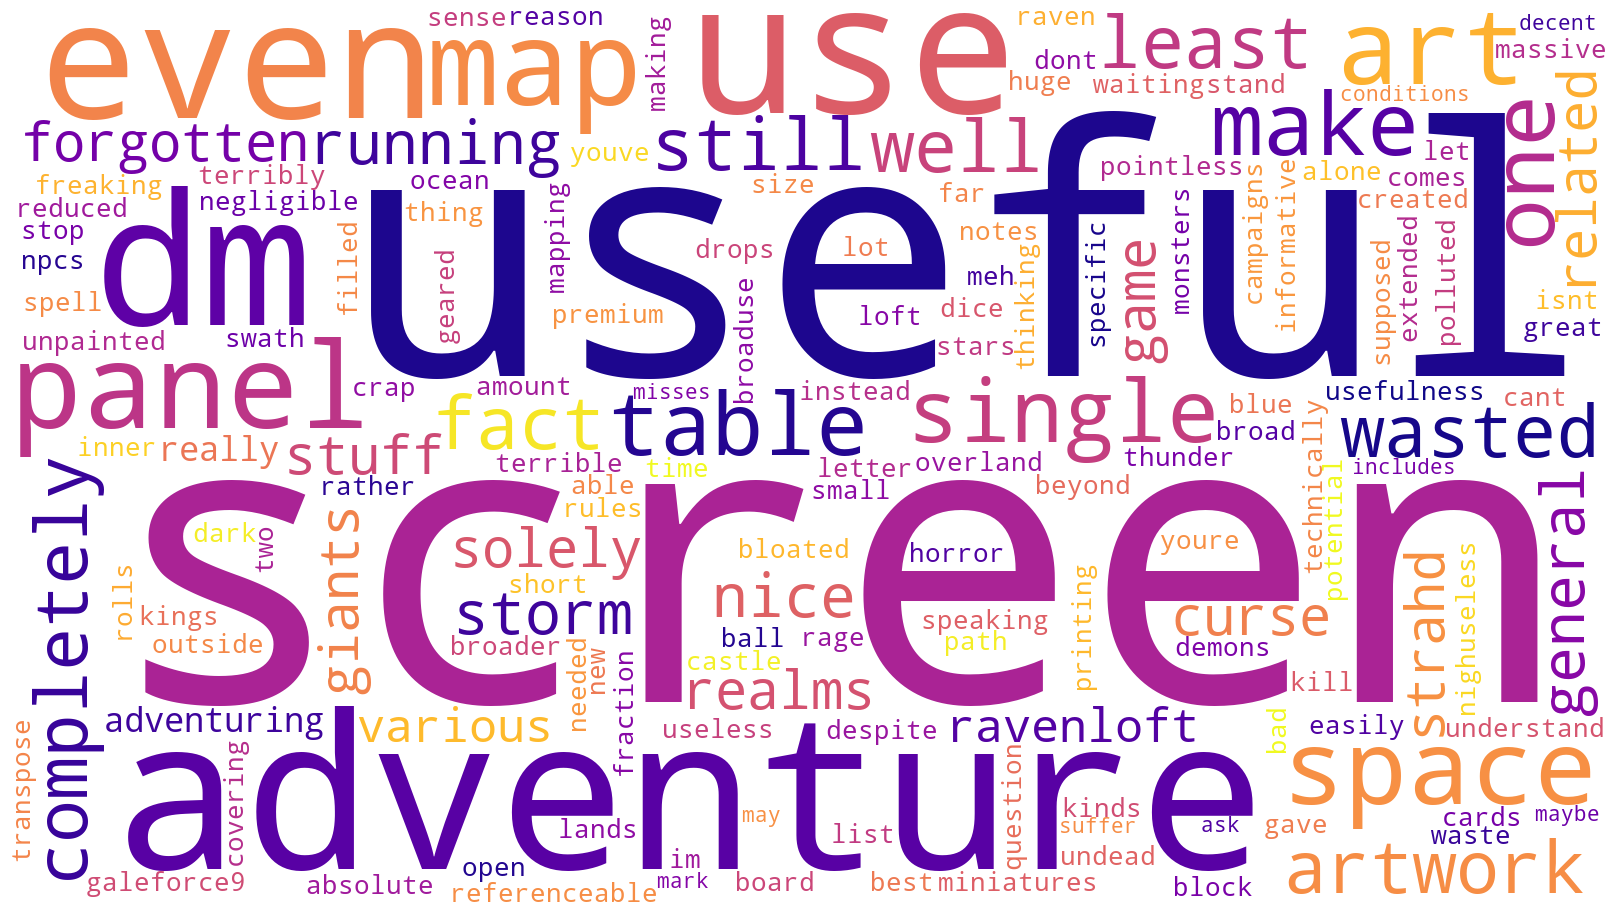

In [21]:
# Create a WordCloud.
wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(tokens_rev2_string) 

# Plot the WordCloud image.                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

### Summaries

In [22]:
all_summaries = ''
for i in range(df4.shape[1]):
    # Add each review.
    all_summaries = all_summaries + df4['summary'][i]
    

In [23]:
# Set the colour palette.
sns.set(color_codes=True)

# Create a WordCloud object.
word_cloud = WordCloud(width = 1600, height = 900, 
                background_color ='white',
                colormap = 'plasma', 
                stopwords = 'none',
                min_font_size = 10).generate(all_summaries) 

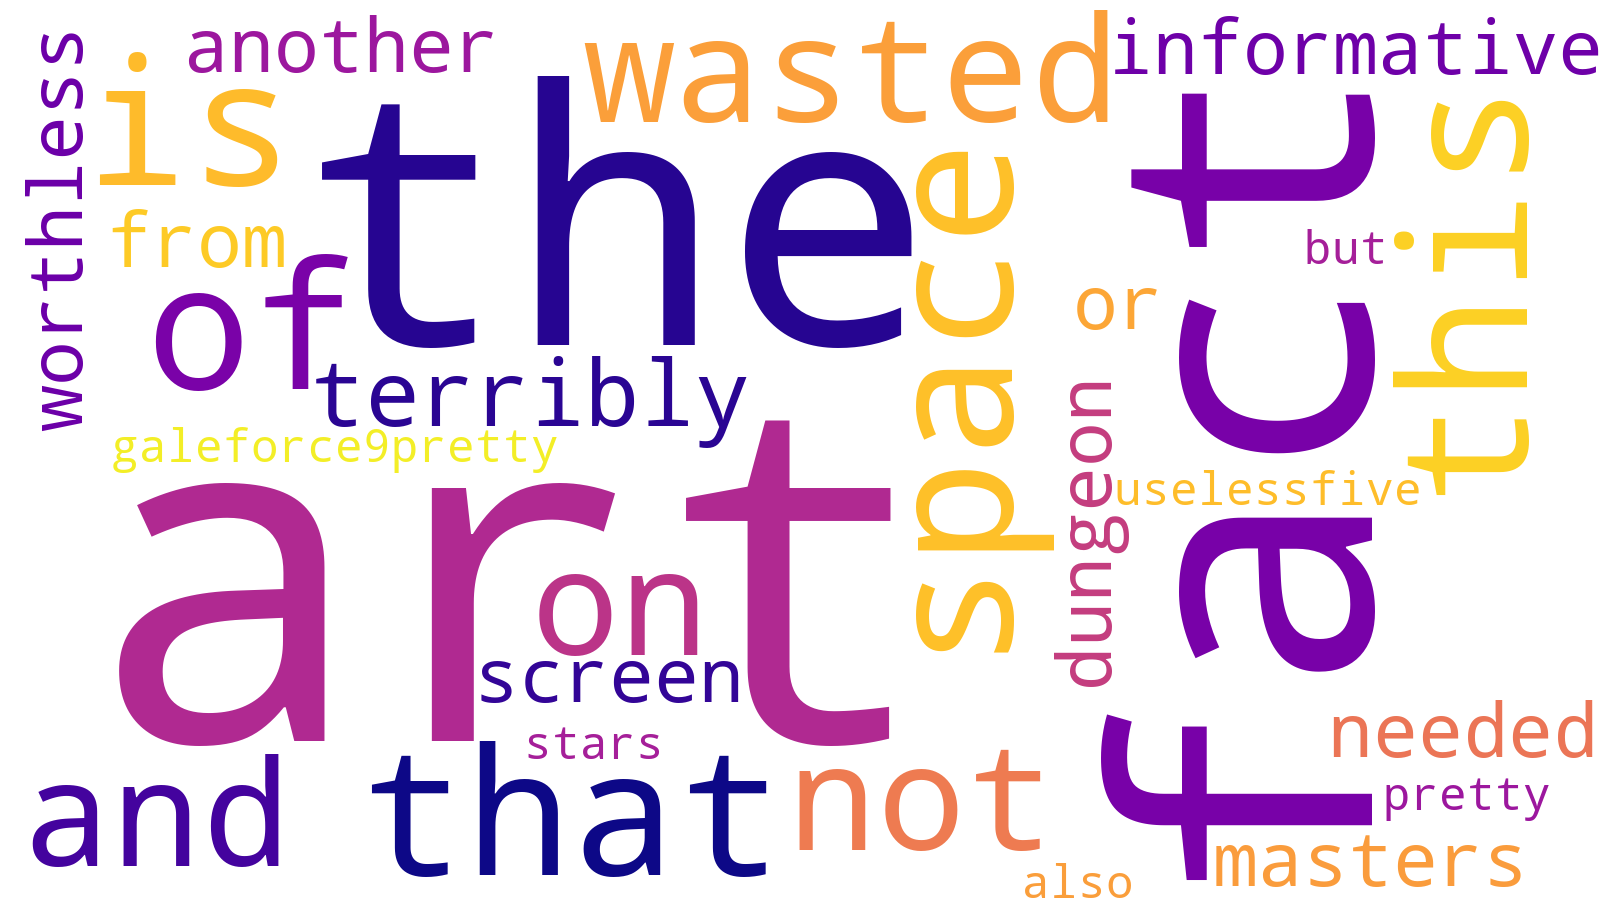

In [24]:
# Plot the WordCloud image.                    
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(word_cloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

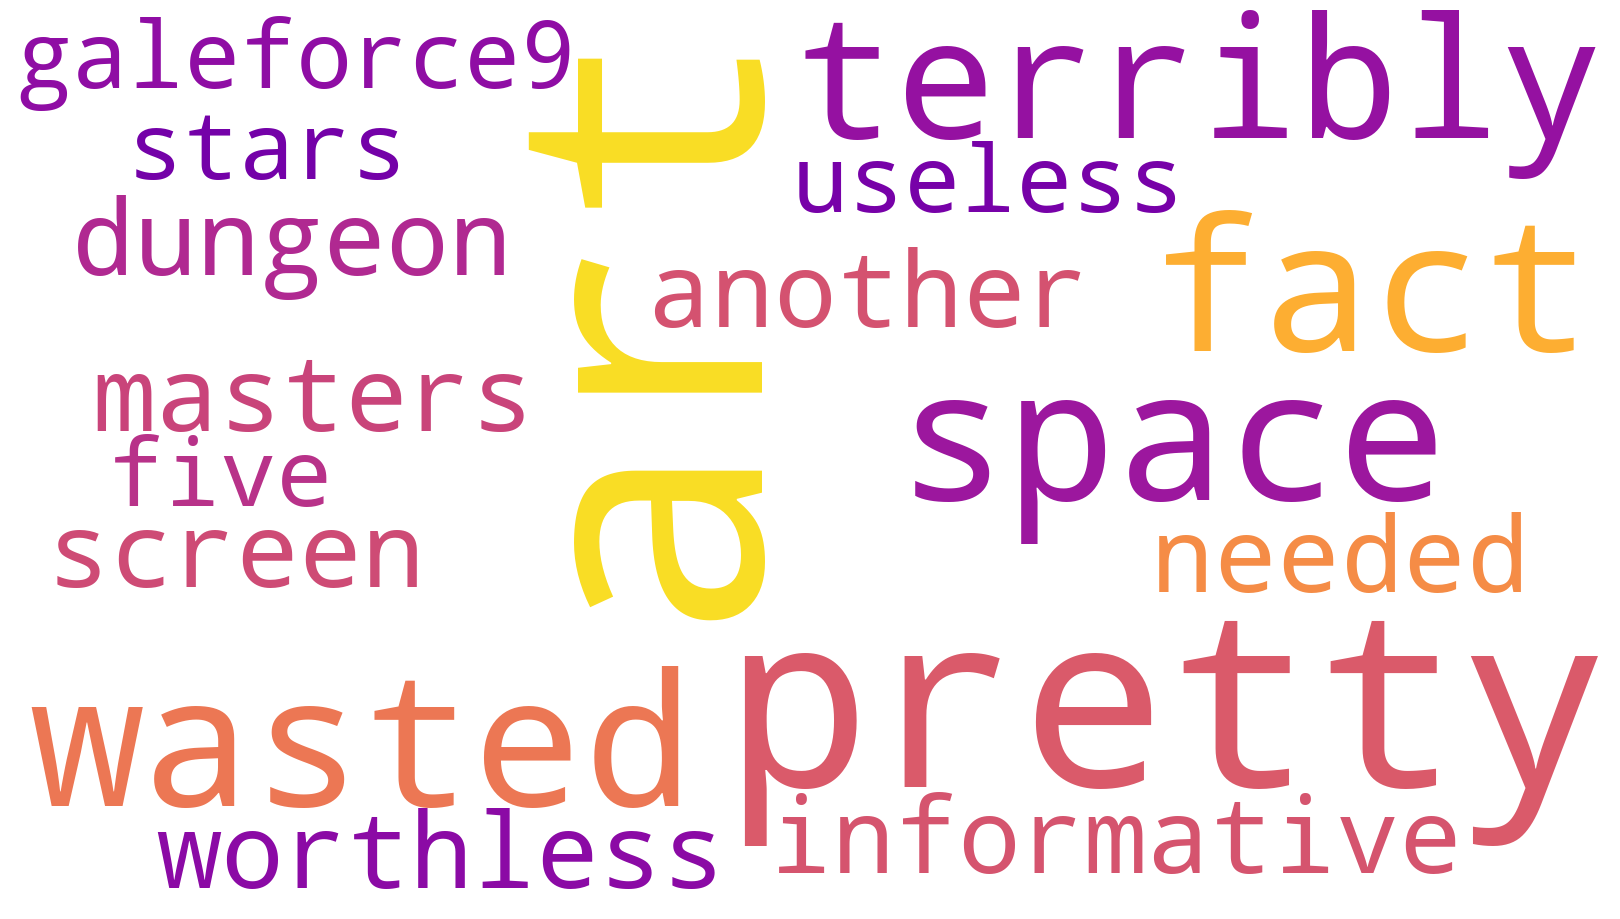

In [25]:
# Create a WordCloud wihtout stop words.
wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(tokens_sum2_string) 

# Plot the WordCloud image.                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

## Create Frequency Distributions for Both Columns

### Reviews

In [26]:
# Import the FreqDist class.
from nltk.probability import FreqDist

In [27]:
# View the frequency distribution.
fdist1 = FreqDist(tokens_rev2)

# Preview the data.
fdist1

FreqDist({'useful': 7, 'screen': 6, 'adventure': 6, 'use': 5, 'screens': 4, 'even': 4, 'map': 4, 'space': 3, 'art': 3, 'dm': 3, ...})

In [44]:
# Import the Counter class.
from collections import Counter

# Generate a DataFrame from Counter.
counts_rev = pd.DataFrame(Counter(tokens_rev2).most_common(15),
                      columns=['Word', 'Frequency']).set_index('Word')

# Preview data.
counts_rev

,Frequency
Word,
useful,7
screen,6
adventure,6
use,5
screens,4
even,4
map,4
space,3
art,3


### Summaries

In [64]:
# View the frequency distribution.
fdist1 = FreqDist(tokens_sum2)

# Preview the data.
fdist1

FreqDist({'art': 2, 'pretty': 2, 'fact': 1, '50': 1, 'space': 1, 'wasted': 1, 'terribly': 1, 'informative': 1, 'needed': 1, 'another': 1, ...})

In [65]:
# Import the Counter class.
from collections import Counter

# Generate a DataFrame from Counter.
counts_sum = pd.DataFrame(Counter(tokens_sum2).most_common(15),
                      columns=['Word', 'Frequency']).set_index('Word')

# Preview data.
counts_sum

,Frequency
Word,
art,2
pretty,2
fact,1
50,1
space,1
wasted,1
terribly,1
informative,1
needed,1


## Extract Polarity

In [49]:
from textblob import TextBlob

In [50]:
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]


In [51]:
def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

In [52]:
df4['polarity_rev'] = df4['review'].apply(generate_polarity)

In [53]:
# Determine sentiment for the first 15 reviews.
df4['polarity_rev'].head(15)

0    -0.036111
1     0.035952
2     0.116640
3     0.578788
4    -0.316667
6     0.660000
8     0.372222
9     0.145537
11    0.000000
12    0.070000
13   -0.040909
14    0.040000
16    0.177288
17    0.290952
18    0.250000
Name: polarity_rev, dtype: float64

In [54]:
df4['subjectivity_rev'] = df4['review'].apply(generate_subjectivity)

df4['subjectivity_rev'].head()

0    0.486111
1    0.442976
2    0.430435
3    0.784848
4    0.316667
Name: subjectivity_rev, dtype: float64

In [55]:
# Create a DataFrame.
negative_sentiment = df4.nsmallest(15, 'polarity_rev')

# Eliminate unnecessary columns.
negative_sentiment = negative_sentiment[['review', 'summary', 'polarity_rev']]

# Eliminate unnecessary columns.
negative_sentiment.style.set_properties(subset=['review'], **{'width': '1200px'})




,review,summary,polarity_rev
208,booo unles you are patient know how to measure i didnt have the patience neither did my daughter boring unless you are a craft person which i am not,boring unless you are a craft person which i am,-1.000000
182,incomplete kit very disappointing,incomplete kit,-0.780000
364,one of my staff will be using this game soon so i dont know how well it works as yet but after looking at the cards i believe it will be helpful in getting a conversation started regarding anger and what to do to control it,anger control game,-0.550000
117,i bought this as a christmas gift for my grandson its a sticker book so how can i go wrong with this gift,stickers,-0.500000
174,i sent this product to my granddaughter the pompom maker comes in two parts and is supposed to snap together to create the pompoms however both parts were the same making it unusable if you cant make the pompoms the kit is useless since this was sent as a gift i do not have it to return very disappointed,faulty product,-0.491667
347,my 8 yearold granddaughter and i were very frustrated and discouraged attempting this craft it is definitely not for a young child i too had difficulty understanding the directions we were very disappointed,frustating,-0.446250
538,i purchased this on the recommendation of two therapists working with my adopted children the children found it boring and put it down half way through,hmmm,-0.440741
437,this game although it appears to be like uno and have an easier play method it was still too time consuming and wordy for my children with learning disabilities,this game although it appears to be like uno and have an easier play method it was,-0.400000
497,my son loves playing this game it was recommended by a counselor at school that works with him,it was recommended by a counselor at school that works with him,-0.400000
989,if you like me used to play dd but now you and your friends growed up and cant be together because all the responsibilities and bla bla bla this game is for you come to the dungeon,like me used to play dd,-0.400000


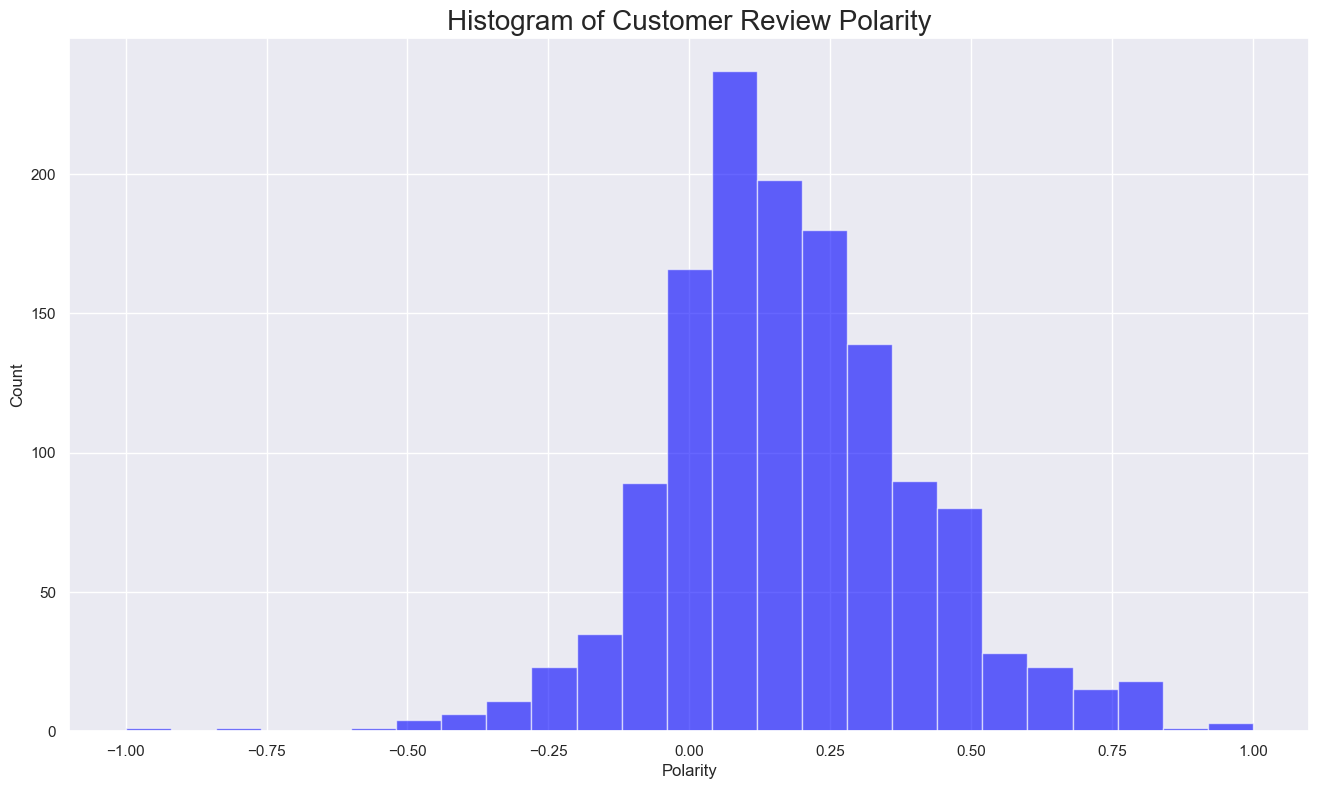

In [66]:
num_bins = 25
plt.figure(figsize = (16,9))

n, bins, parches = plt.hist(df4['polarity_rev'], num_bins, facecolor = 'blue', alpha = 0.6)


plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of Customer Review Polarity', fontsize=20)

plt.show()


### Summaries

In [58]:
df4['polarity_sum'] = df4['summary'].apply(generate_polarity)

In [59]:
# Determine sentiment for the first 15 summaries.
df4['polarity_sum'].head(15)

0     0.15000
1    -0.80000
2     0.00000
3     0.00000
4     0.00000
6     1.00000
8     0.65000
9     0.00000
11    0.50000
12   -0.02500
13   -0.44375
14   -0.02500
16    0.70000
17    0.00000
18    0.61000
Name: polarity_sum, dtype: float64

In [60]:
df4['subjectivity_sum'] = df4['summary'].apply(generate_subjectivity)

df4['subjectivity_sum'].head(15)

0     0.500000
1     0.900000
2     0.733333
3     0.000000
4     0.000000
6     0.300000
8     0.625000
9     0.000000
11    0.600000
12    0.500000
13    0.606250
14    0.125000
16    0.600000
17    0.000000
18    0.690000
Name: subjectivity_sum, dtype: float64

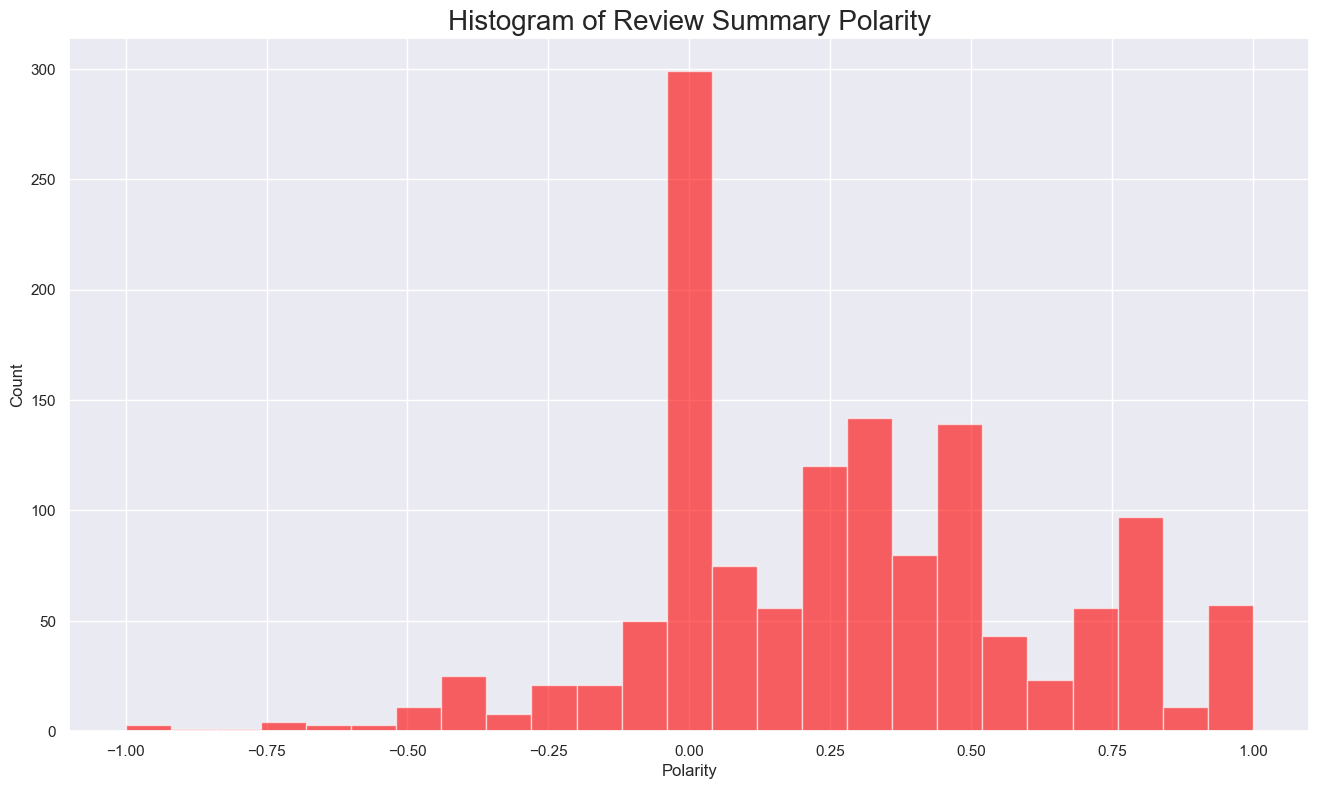

In [63]:
num_bins = 25
plt.figure(figsize = (16,9))

n, bins, parches = plt.hist(df4['polarity_sum'], num_bins, facecolor = 'red', alpha = 0.6)


plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of Review Summary Polarity', fontsize=20)

plt.show()